# Factors of a Box Office Success

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Imports

In [377]:
import pandas as pd
import zipfile
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Markdown
import difflib
import re
import requests
from bs4 import BeautifulSoup
import time
import math
import tempfile

# Loading the Data

## im.db sqlite file
github only allows files up to 100MB so we must keep the im.db zipped and also work on it.

In [378]:
# Extract the database file to a temporary directory
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
    with z.open('im.db') as f:
        with tempfile.NamedTemporaryFile(delete=False) as temp_db:
            temp_db.write(f.read())
            temp_db_path = temp_db.name

# Connect to the SQLite database
conn = sqlite3.connect(temp_db_path)

# Query to list all tables
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
display(tables)

# Query to get the first 10 rows from the 'movie_basics' table
df = pd.read_sql_query("SELECT * FROM movie_basics LIMIT 10", conn)
display(df.info())

# Close the connection
conn.close()



,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         10 non-null     object 
 1   primary_title    10 non-null     object 
 2   original_title   10 non-null     object 
 3   start_year       10 non-null     int64  
 4   runtime_minutes  7 non-null      float64
 5   genres           10 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 608.0+ bytes


None

## CSVs
Again we leave them zipped, pandas handles that for us.

In [341]:
bom_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
display(bom_movie_gross.head())

tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
display(tmdb_movies.head())

tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
display(tn_movie_budgets.head())

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## TSVs
They needed latin encoding or they didn't load right

In [342]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='latin1')
display(rt_movie_info.head())

rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')
display(rt_reviews.head())

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police drama earned five Academy Awards, including Best Picture, Best Adapted Screenplay (written by Ernest Tidyman), and Best Actor (Gene Hackman). Jimmy ""Popeye"" Doyle (Hackman) and his partner, Buddy Russo (Roy Scheider), are New York City police detectives on narcotics detail, trying to track down the source of heroin from Europe into the United States. Suave Alain Charnier (Fernando Rey) is the French drug kingpin who provides a large percentage of New York City's dope, and Pierre Nicoli (Marcel Bozzuffi) is a hired killer and Charnier's right-hand man. Acting on a hunch, Popeye and Buddy start tailing Sal Boca (Tony Lo Bianco) and his wife, Angie (Arlene Faber), who live pretty high for a couple whose corner store brings in about 7,000 dollars a year. It turns out Popeye's suspicions are right -- Sal and Angie are the New York agents for Charnier, who will be smuggling 32 million dollars' worth of heroin into the city in a car shipped over from France. The French Connection broke plenty of new ground for screen thrillers; Popeye Doyle was a highly unusual ""hero,"" an often violent, racist, and mean-spirited cop whose dedication to his job fell just short of dangerous obsession. The film's high point, a high-speed car chase with Popeye tailing an elevated train, was one of the most viscerally exciting screen moments of its day and set the stage for dozens of action sequences to follow. And the film's grimy realism (and downbeat ending) was a big change from the buff-and-shine gloss and good-guys-always-win heroics of most police dramas that preceded it. The French Connection was inspired by a true story, and Eddie Egan and Sonny Grosso, Popeye and Buddy's real life counterparts, both have small roles in the film. A sequel followed four years later.",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Packer, a 28 year-old finance golden boy dreaming of living in a civilization ahead of this one, watches a dark shadow cast over the firmament of the Wall Street galaxy, of which he is the uncontested king. As he is chauffeured across midtown Manhattan to get a haircut at his father's old barber, his anxious eyes are glued to the yuan's exchange rate: it is mounting against all expectations, destroying Eric's bet against it. Eric Packer is losing his empire with every tick of the clock. Meanwhile, an eruption of wild activity unfolds in the city's streets. Petrified as the threats of the real world infringe upon his cloud of virtual convictions, his paranoia intensifies during the course of his 24-hour cross-town odyssey. Packer starts to piece together clues that lead him to a most terrifying secret: his imminent assassination. -- (C) Official Site",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,"Illeana Douglas delivers a superb performance as Denise Waverly, a fictional singer and songwriter whose life bears more than a passing resemblance to that of real-life pop star Carole King. Edna Buxton, the daughter of a Philadelphia steel tycoon, aspires to a career as a singer, and when against her mother's bidding she sings a sultry version of ""Hey There (You With the Stars in Your Eyes)"" (instead of Mom's choice, ""You'll Never Walk Alone"") at a talent contest, she wins a recording contact and moves to New York City. She cuts a record and gains a new stage name, Denise Waverly; however, she soon finds that girl singers are a dime a dozen in the Big Apple and her career as a vocalist goes nowhere. But she has a knack for writing songs, and eccentric producer Joel Milner (John Turturro) asks her to pen some songs for his upcoming projects. Teamed with Howar

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,"A distinctly gallows take on contemporary financial mores, as one absurdly rich man's limo ride across town for a haircut functions as a state-of-the-nation discourse.",3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that never arrives...It's just old-fashioned bad storytelling.,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealings and digital communications and brief face-to-face conversations and sexual intermissions in a space shuttle of a limousine creeping through the gridlock of an anonymous New York City.,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,"Continuing along a line introduced in last year's ""A Dangerous Method"", David Cronenberg pushes his cinema towards a talky abstraction in his uncanny, perversely funny and frighteningly insular adaptation of Don DeLillo, ""Cosmopolis"".",NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## Recent IMDb Info from Flat Files

We obtained recent data from the [IMDb Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/) and trimmed it down to the last 10 years to fit within GitHub's file size limits.

This data was merged with reviews from the same source and saved as a DataFrame pickle file. The processing was done in a separate folder to avoid kernel crashes caused by the large file size. Chunking solved this issue, but to keep this notebook manageable, we store and load the pickle file here.

The file is `additional_data/imdb_flat_files/filtered_title_basics.tsv.gz`. From this, we parsed out the last 3 years of movie data to focus on what currently works at the box office and saved it as a pickle file `additional_data/last_three_years_movies_with_ratings.pkl`. However, it is used as a base for API calls to get more data, so it is not loaded here either.

### IMDb Flat File Last Ten Years

While we won't load the last 3 years pickle file we will load the last 10 years of IMDb data to check if the `im.db` and the flat files we have agree data-wise.

In [343]:
def load_gzipped_tsv_in_chunks(file_path, chunk_size=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, delimiter='\t', encoding='utf-8', chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

imdb_last_ten_years = load_gzipped_tsv_in_chunks('additional_data/imdb_flat_files/filtered_title_basics.tsv.gz')
#display(imdb_last_ten_years.head())

imdb_last_ten_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195091 entries, 0 to 195090
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         195091 non-null  object 
 1   title_type       195091 non-null  object 
 2   primary_title    195091 non-null  object 
 3   original_title   195091 non-null  object 
 4   is_adult         195091 non-null  int64  
 5   start_year       195091 non-null  int64  
 6   end_year         0 non-null       float64
 7   runtime_minutes  145508 non-null  float64
 8   genres           195091 non-null  object 
 9   averagerating    101899 non-null  float64
 10  numvotes         101899 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 16.4+ MB


In [344]:
imdb_last_ten_years['movie_id'].value_counts()

tt0011801     1
tt4481484     1
tt4480930     1
tt4480936     1
tt4481066     1
             ..
tt21029334    1
tt21029338    1
tt21029594    1
tt21029660    1
tt9916730     1
Name: movie_id, Length: 195091, dtype: int64

### Lets Select From im.db To Match The Format


In [345]:
sql = """
SELECT mb.*,mr.averagerating,mr.numvotes
FROM movie_basics mb
JOIN movie_ratings mr on mr.movie_id=mb.movie_id
WHERE start_year >= strftime('%Y', 'now', '-10 years')
"""
im_db = pd.read_sql_query(sql,conn)
display(im_db.info())
display(im_db.head())

display(im_db['movie_id'].isnull().sum())
display(im_db['movie_id'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44005 entries, 0 to 44004
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         44005 non-null  object 
 1   primary_title    44005 non-null  object 
 2   original_title   44005 non-null  object 
 3   start_year       44005 non-null  int64  
 4   runtime_minutes  39314 non-null  float64
 5   genres           43570 non-null  object 
 6   averagerating    44005 non-null  float64
 7   numvotes         44005 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.7+ MB


None

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
2,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
3,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
4,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",4.1,32


0

tt0066787    1
tt6084816    1
tt6083652    1
tt6083734    1
tt6084014    1
            ..
tt4180640    1
tt4180650    1
tt4181052    1
tt4181194    1
tt9916160    1
Name: movie_id, Length: 44005, dtype: int64

## Comparing The Two
There is a huge difference in the size of the datasets for the last 10 years.

In [346]:
# Merge both datasets on the movie_id using an inner join
merged_df = pd.merge(imdb_last_ten_years, im_db, on='movie_id', suffixes=('_flat', '_sql'), how='inner')

# Function to calculate scores
def calculate_scores(row, col):
    score_flat = 0
    score_sql = 0

    value_flat = row[col + '_flat']
    value_sql = row[col + '_sql']

    if pd.isna(value_flat) and pd.notna(value_sql):
        score_sql += 1
    elif pd.notna(value_flat) and pd.isna(value_sql):
        score_flat += 1
    elif pd.notna(value_flat) and pd.notna(value_sql):
        # Give them both a point if values are equal, this will make the score more intuitively correct if the two data sets mostly agree
        if value_flat == value_sql:
            score_flat += 1
            score_sql += 1
        # Penalize both for numeric discrepancies
        elif isinstance(value_flat, (int, float)) and isinstance(value_sql, (int, float)):
            score_flat -= 1
            score_sql -= 1
        elif isinstance(value_flat, str) and isinstance(value_sql, str):
            if len(value_flat) > len(value_sql):
                score_flat += 0.5
            elif len(value_flat) < len(value_sql):
                score_sql += 0.5

    return score_flat, score_sql

# Initialize scores
total_score_flat = 0
total_score_sql = 0

# Calculate scores for each row and column
for col in ['primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']:
    for _, row in merged_df.iterrows():
        rflat, rsql = calculate_scores(row, col)
        total_score_flat += rflat
        total_score_sql += rsql

# Print total scores
print(f"Total Score for IMDb Flat Files: {total_score_flat}")
print(f"Total Score for IMDb SQL Database: {total_score_sql}")

Total Score for IMDb Flat Files: 202377.5
Total Score for IMDb SQL Database: 198181.5


## Make movies_df
merge the two dataframes preferring the more up to date info where they overlap

In [347]:
# Merging im_db and imdb_last_ten_years dataframes, preferring values from imdb_last_ten_years
# Concatenate the DataFrames
combined_df = pd.concat([im_db, imdb_last_ten_years], ignore_index=True)

# Drop duplicates based on 'movie_id', keeping the first occurrence (from imdb_last_ten_years)
movies_df = combined_df.drop_duplicates(subset='movie_id', keep='last').reset_index(drop=True)

# Optional: Display the resulting DataFrame
display(movies_df)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
195957,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0.0,NaN
195958,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0.0,NaN
195959,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0.0,NaN
195960,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0.0,NaN


In [348]:
#Clear up memory
merged_df = None
im_db = None
imdb_last_ten_years = None

### Results of Comparison
It seems the data isn't too different, but as might be expected the newer data scores better.  This makes sense because newer data is often more filled out on sites that collect data.
So we would benefit with preferring the updated data set for both the score and reasoning.

We could merge the data sets to fill in missing, but missing info could be corrections in the new data set.  Likewise changes to genres could be intentional and more correct.

However, later on, we can leverage the fact the im.db goes further back and has things on actors etc if we need to.



## [Rapid API Movies Database](https://rapidapi.com/SAdrian/api/moviesdatabase)
This Movies Database has info we need, mainly box office data and production costs.  We also got as much else as we could though.

The `additional_data/last_three_years_movies_with_ratings.pkl` was used as the base and using the imdb id we fetched additional info on the following:
```python
infos = ["base_info", "genres", "revenue_budget", "releaseDate", "rating", "awards"]
```

The final merged results are loaded below in a pickle file, giving us comprehensive data on the last three years of movie data!

In [349]:
movie_detailed = pd.read_pickle('additional_data/final_filtered_last_three_years_data.pkl')
movie_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68006 entries, 0 to 68005
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_id               68006 non-null  object 
 1   title_type             68006 non-null  object 
 2   primary_title          68006 non-null  object 
 3   original_title         68006 non-null  object 
 4   is_adult               68006 non-null  object 
 5   start_year             68006 non-null  int64  
 6   end_year               68006 non-null  object 
 7   runtime_minutes        68006 non-null  object 
 8   genres                 68006 non-null  object 
 9   average_rating         32777 non-null  float64
 10  num_votes              32777 non-null  float64
 11  md_average_rating      32854 non-null  float64
 12  md_num_votes           67871 non-null  float64
 13  image_url              47166 non-null  object 
 14  image_caption          47166 non-null  object 
 15  md

Unfortunately after all that work (over 12 hours worth), the number of box office revenu columns we got was very small.  So we won't be able to use it much.

## Additional Data
We might use this later but we'll have to hand copy it.
https://the-numbers.com/movies/report/All/All/All/All/All/All/All/All/All/None/None/2020/2020/None/None/None/None/None/None?show-release-date=On&view-order-by=domestic-box-office&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-inflation-adjusted-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&show-genre=On

# Data Exploration
Lets see what we have, identify what we can clean and then combine

## Summarize Our Data
We need a birds eye view of what we're looking at

In [350]:
# Connect to the database
conn = sqlite3.connect('/tmp/im.db')

# Function to summarize a dataframe
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Values': [get_top_values(df[col]) for col in df.columns]
    })
    return summary

# Function to get top 5 values by frequency
def get_top_values(series):
    top_values = Counter(series.dropna()).most_common(5)
    return [val[0] for val in top_values]
# Function to display summary with heading
def display_summary(title, df):
    p_md(title)
    display(summarize_dataframe(df))

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))


# Adjust display options to show more content in cells
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Display summaries
p_md("**Summaries**")

def im_db_tables_summaries():
    # Summarize im.db tables
    im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

    for table_name in im_db_tables['name']:
        display_summary(f"**table {table_name} in im.db:**", pd.read_sql_query(f"SELECT * FROM {table_name}", conn))

def df_summaries():
    # Movies DF
    display_summary("**movies_df dataframe:**", movies_df)

    # Summarize CSV dataframes
    display_summary("**bom_movie_gross dataframe:**", bom_movie_gross)
    display_summary("**tmdb_movies dataframe:**", tmdb_movies)
    display_summary("**tn_movie_budgets dataframe:**", tn_movie_budgets)

    # Summarize TSV dataframes
    display_summary("**rt_movie_info dataframe:**", rt_movie_info)
    display_summary("**rt_reviews dataframe:**", rt_reviews)

im_db_tables_summaries()
df_summaries()

**Summaries**

**table movie_basics in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,146144,object,146144,"[tt0063540, tt0066787, tt0069049, tt0069204, tt0100275]"
1,primary_title,146144,object,136071,"[Home, Broken, The Return, Alone, Homecoming]"
2,original_title,146123,object,137773,"[Broken, Home, The Return, Alone, The Gift]"
3,start_year,146144,int64,19,"[2017, 2016, 2018, 2015, 2014]"
4,runtime_minutes,114405,float64,367,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,140736,object,1085,"[Documentary, Drama, Comedy, Horror, Comedy,Drama]"


**table directors in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,291174,object,140417,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,291174,object,109253,"[nm6935209, nm2563700, nm1546474, nm3877467, nm3848412]"


**table known_for in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,1638260,object,576444,"[nm1202937, nm4291122, nm0958522, nm0509978, nm0218305]"
1,movie_id,1638260,object,514781,"[tt0806910, tt0441074, tt0203259, tt0486531, tt0452046]"


**table movie_akas in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,331703,object,122302,"[tt2488496, tt2310332, tt1201607, tt2278871, tt1790809]"
1,ordering,331703,int64,61,"[1, 2, 3, 4, 5]"
2,title,331703,object,252781,"[Robin Hood, Home, Alone, Broken, Love]"
3,region,278410,object,213,"[US, XWW, RU, DE, FR]"
4,language,41715,object,76,"[en, tr, bg, fr, he]"
5,types,168447,object,10,"[imdbDisplay, original, working, alternative, festival]"
6,attributes,14925,object,77,"[new title, alternative spelling, literal English title, complete title, original subtitled version]"
7,is_original_title,331678,float64,2,"[0.0, 1.0]"


**table movie_ratings in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,73856,object,73856,"[tt10356526, tt10384606, tt1042974, tt1043726, tt1060240]"
1,averagerating,73856,float64,91,"[7.0, 6.6, 7.2, 6.8, 6.5]"
2,numvotes,73856,int64,7349,"[6, 5, 7, 8, 9]"


**table persons in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,606648,object,606648,"[nm0061671, nm0061865, nm0062070, nm0062195, nm0062798]"
1,primary_name,606648,object,577203,"[James Brown, Michael Brown, David Brown, Michael Johnson, Mark Davis]"
2,birth_year,82736,float64,267,"[1978.0, 1980.0, 1979.0, 1982.0, 1981.0]"
3,death_year,6783,float64,214,"[2018.0, 2017.0, 2016.0, 2015.0, 2013.0]"
4,primary_profession,555308,object,8647,"[actor, actress, producer, composer, writer]"


**table principals in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,1028186,object,143454,"[tt0323808, tt0417610, tt0469152, tt0475290, tt0477302]"
1,ordering,1028186,int64,10,"[1, 2, 3, 4, 5]"
2,person_id,1028186,object,604546,"[nm1930572, nm0000636, nm0000616, nm0103977, nm4394575]"
3,category,1028186,object,12,"[actor, director, actress, producer, cinematographer]"
4,job,177684,object,2965,"[producer, screenplay, director of photography, writer, co-director]"
5,characters,393360,object,174762,"[[""Himself""], [""Herself""], [""Narrator""], [""Alex""], [""David""]]"


**table writers in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,255873,object,110261,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,255873,object,122576,"[nm6935209, nm1546474, nm0000636, nm2780568, nm4677186]"


**movies_df dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,195962,object,195962,"[tt0066787, tt0069204, tt0170651, tt0253093, tt0263814]"
1,primary_title,195962,object,180744,"[The Return, Alone, The Stranger, Hero, Home]"
2,original_title,195962,object,183518,"[The Return, Alone, Home, Karma, Run]"
3,start_year,195962,int64,18,"[2022, 2023, 2018, 2017, 2019]"
4,runtime_minutes,146201,float64,425,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,195931,object,1140,"[Documentary, Drama, Comedy, \N, Horror]"
6,averagerating,102770,float64,91,"[6.4, 6.8, 6.6, 7.0, 6.2]"
7,numvotes,102770,float64,9162,"[7.0, 8.0, 9.0, 6.0, 10.0]"
8,title_type,195091,object,1,[movie]
9,is_adult,195091,float64,2,"[0.0, 1.0]"


**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,object,1204,"[1200000, 1100000, 1900000, 4200000, 2500000]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,object,3433,"[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,object,2418,"[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,object,509,"[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]"
4,domestic_gross,5782,object,5164,"[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]"
5,worldwide_gross,5782,object,5356,"[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]"


**rt_movie_info dataframe:**

Column  Non-Null Count   Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,40915,object,186,"[3/5, 4/5, 3/4, 2/5, 2/4]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,object,5963,"[January 1, 2000, May 20, 2003, December 6, 2005, September 7, 2011, July 26, 2002]"


Awesome! This summary will let us see all sorts of useful info and we can refer back to it during the entire project!

Time to roll up our sleeves and use this summary to try to identify places that need cleaning.

## Analyze Columns
Lets analyze, algorithmically!  This will let us generalize the problem.  We will still manually go over it but this should let us find things that would otherwise be missed, or take untold time to find.

In [374]:
# Function to determine if a column contains date time values
def is_datetime(series):
    try:
        pd.to_datetime(series, errors='raise')
        return True
    except:
        return False

# Function to determine if a column contains money values
def is_money(series):
    # List of common currency symbols
    currency_symbols = r'[$€£¥₹]'
    # Regex pattern for money values
    money_pattern = rf'{currency_symbols}?\d+(,\d{{3}})*(\.\d{{2}})?'
    return series.dropna().astype(str).str.match(money_pattern).all()

# Function to determine if a column contains numeric values
def is_numeric(series):
    try:
        pd.to_numeric(series, errors='raise')
        return True
    except:
        return False

def analyze_dataframe(df, df_name):
    missing_data_cols = []
    high_missing_data_cols = []
    duplicate_value_cols = []
    incorrect_dtype_cols = []
    potential_duplicates_dict = {}

    # Identify columns with missing data
    for col in df.columns:
        sumnull = int(df[col].isnull().sum())
        sumall = int(df[col].count())
        
        if sumnull > 0:
            missing_data_cols.append(col)
        
        if sumall > 0 and (sumnull / sumall) > 0.4:
            high_missing_data_cols.append(col)
    
        if df[col].dtype == 'object':
            # Find wrong data types
            #This wasn't reliable to find data type issues
            '''
            if is_numeric(df[col]):
                incorrect_dtype_cols.append((col, 'numeric'))
            elif is_datetime(df[col]):
                incorrect_dtype_cols.append((col, 'datetime'))
            elif is_money(df[col]):
                incorrect_dtype_cols.append((col, 'money'))
            else:
            ''' 
            #takes over 2 hours and still didn't complete so we can't find mislabled data via expensive computation
            '''
            # Find potential data that has malformed labels using value counts under 10
            value_counts = df[col].dropna().value_counts()
            unique_values = value_counts.index[value_counts < 10]
            potential_duplicates = []
            
            set_dict = {value: set(value.lower().split()) for value in unique_values}
            
            for value, set1 in set_dict.items():
                for other_value, set2 in set_dict.items():
                    if value != other_value and len(set1 & set2) / max(len(set1), len(set2)) > 0.86:
                        potential_duplicates.append((value, other_value))
            
            if potential_duplicates:
                duplicate_value_cols.append(col)
                potential_duplicates_dict[col] = potential_duplicates
            '''
    # Print the findings for the current dataframe
    p_md(f"### Analysis for {df_name}:")
    if len(missing_data_cols) > 0:
        p_md(f"**missing data:** {missing_data_cols}")
    if len(high_missing_data_cols) > 0:
        p_md(f"**high missing data:** {high_missing_data_cols}")
    if len(duplicate_value_cols) > 0:
        p_md(f"**potential duplicate value issues:** {duplicate_value_cols}")
    if len(incorrect_dtype_cols) > 0:
        p_md(f"**incorrect data types:** {incorrect_dtype_cols}")

    for col, duplicates in potential_duplicates_dict.items():
        p_md(f"**Column:** {col} Potential Duplicates")
        for dup in duplicates:
            p_md(f"{dup[0]} <-> {dup[1]}")

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))

# Analyzing each dataframe
def analyze_all_dataframes():
    # IMDb database tables
    im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
    for table_name in im_db_tables['name']:
        table_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        analyze_dataframe(table_df, f"table {table_name} in im.db")

    #movies_df
    analyze_dataframe(movies_df, "movies_df dataframe")

    # CSV dataframes
    analyze_dataframe(bom_movie_gross, "bom_movie_gross dataframe")
    analyze_dataframe(tmdb_movies, "tmdb_movies dataframe")
    analyze_dataframe(tn_movie_budgets, "tn_movie_budgets dataframe")

    # TSV dataframes
    analyze_dataframe(rt_movie_info, "rt_movie_info dataframe")
    analyze_dataframe(rt_reviews, "rt_reviews dataframe")

analyze_all_dataframes()

### Analysis for table movie_basics in im.db:

**missing data:** ['original_title', 'runtime_minutes', 'genres']

### Analysis for table directors in im.db:

### Analysis for table known_for in im.db:

### Analysis for table movie_akas in im.db:

**missing data:** ['region', 'language', 'types', 'attributes', 'is_original_title']

**high missing data:** ['language', 'types', 'attributes']

### Analysis for table movie_ratings in im.db:

### Analysis for table persons in im.db:

**missing data:** ['birth_year', 'death_year', 'primary_profession']

**high missing data:** ['birth_year', 'death_year']

### Analysis for table principals in im.db:

**missing data:** ['job', 'characters']

**high missing data:** ['job', 'characters']

### Analysis for table writers in im.db:

### Analysis for movies_df dataframe:

**missing data:** ['runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_type', 'is_adult', 'end_year', 'directors', 'writers', 'studio', 'domestic_gross', 'foreign_gross', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross']

**high missing data:** ['averagerating', 'numvotes', 'directors', 'writers', 'studio', 'domestic_gross', 'foreign_gross', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross']

### Analysis for bom_movie_gross dataframe:

**missing data:** ['studio', 'domestic_gross', 'foreign_gross']

**high missing data:** ['foreign_gross']

### Analysis for tmdb_movies dataframe:

### Analysis for tn_movie_budgets dataframe:

### Analysis for rt_movie_info dataframe:

**missing data:** ['rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']

**high missing data:** ['writer', 'currency', 'box_office', 'studio']

### Analysis for rt_reviews dataframe:

**missing data:** ['review', 'rating', 'critic', 'publisher']

**high missing data:** ['rating']

# Data Cleaning
In this section we clean data

## Correct Data Types We Detect

### Columns identified to have the wrong data types
We did this by hand
<pre>
tmdb_movies dataframe:
release_date	26517	object	3433	[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]

bom_movie_gross
3	foreign_gross	2037	object	1204	[1200000, 1100000, 1900000, 4200000, 2500000]

tn_movie_budgets dataframe:
1	release_date	5782	object	2418	[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]
3	production_budget	5782	object	509	[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]
4	domestic_gross	5782	object	5164	[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]
5	worldwide_gross	5782	object	5356	[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]

rt_movie_info dataframe:
6	theater_date	1560	int64	1026	[-9223372036854775808, 536457600000000000, 757382400000000000, -126230400000000000, 94694400000000000]
7	dvd_date	1560	int64	718	[-9223372036854775808, 1086048000000000000, 1005004800000000000, 1031011200000000000, 872640000000000000]
9	box_office	340	object	336	[600,000, 200,000, 32,000,000, 20,900,803, 41,032,915]
10	runtime	1530	object	142	[90 minutes, 95 minutes, 100 minutes, 93 minutes, 96 minutes]

rt_reviews dataframe:
2	rating	40915	object	186	[3/5, 4/5, 3/4, 2/5, 2/4
7	date	54432	object	5963	[January 1, 2000, May 20, 2003, December 6, 2005, September 7, 2011, July 26, 2002]


movies_df dataframe:
9	is_adult	195091	float64	2	[0.0, 1.0]
</pre>

In [352]:
# Define the clean_money_column function
def clean_money_column(series):
    series = series.astype(str).str.replace(r'[\$,€£¥₹]', '', regex=True)
    series = series.str.replace(r',(\d\d)$', r'.\1', regex=True)
    return pd.to_numeric(series, errors='coerce')

# Define the clean_runtime_column function
def clean_runtime_column(series):
    return series.astype(str).str.replace(' minutes', '').astype(float)

tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

bom_movie_gross['foreign_gross'] = clean_money_column(bom_movie_gross['foreign_gross'])

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'], errors='coerce')
tn_movie_budgets['production_budget'] = clean_money_column(tn_movie_budgets['production_budget'])
tn_movie_budgets['domestic_gross'] = clean_money_column(tn_movie_budgets['domestic_gross'])
tn_movie_budgets['worldwide_gross'] = clean_money_column(tn_movie_budgets['worldwide_gross'])

def clean_rt_movie_info():
    rt_movie_info['theater_date'] = pd.to_datetime(rt_movie_info['theater_date'], errors='coerce')
    rt_movie_info['dvd_date'] = pd.to_datetime(rt_movie_info['dvd_date'], errors='coerce')
    rt_movie_info['box_office'] = clean_money_column(rt_movie_info['box_office'])
    rt_movie_info['runtime'] = clean_runtime_column(rt_movie_info['runtime'])
    rt_movie_info['synopsis'] = rt_movie_info['synopsis'].astype(str)

clean_rt_movie_info()

# Define the to_percentage function
def to_percentage(value):
    if isinstance(value, float):
        return value
    parts = value.split('/')
    if len(parts) == 2:
        num = parts[0]
        denom = parts[1]
        if num.isdigit() and denom.isdigit():
            num = int(num)
            denom = int(denom)
            if denom > 0:
                return num / denom
    return None

# Apply the to_percentage function to the rating column
rt_reviews['rating'] = rt_reviews['rating'].map(to_percentage)
rt_reviews['date'] = pd.to_datetime(rt_reviews['date'], errors='coerce')

movies_df['is_adult'] = movies_df['is_adult'].astype('Int64')



In [353]:
#Lets check we were successful
#im_db_tables_summaries()
df_summaries()

**movies_df dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,195962,object,195962,"[tt0066787, tt0069204, tt0170651, tt0253093, tt0263814]"
1,primary_title,195962,object,180744,"[The Return, Alone, The Stranger, Hero, Home]"
2,original_title,195962,object,183518,"[The Return, Alone, Home, Karma, Run]"
3,start_year,195962,int64,18,"[2022, 2023, 2018, 2017, 2019]"
4,runtime_minutes,146201,float64,425,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,195931,object,1140,"[Documentary, Drama, Comedy, \N, Horror]"
6,averagerating,102770,float64,91,"[6.4, 6.8, 6.6, 7.0, 6.2]"
7,numvotes,102770,float64,9162,"[7.0, 8.0, 9.0, 6.0, 10.0]"
8,title_type,195091,object,1,[movie]
9,is_adult,195091,Int64,2,"[0, 1]"


**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,float64,1204,"[1200000.0, 1100000.0, 1900000.0, 4200000.0, 2500000.0]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,datetime64[ns],3433,"[2010-01-01 00:00:00, 2011-01-01 00:00:00, 2012-01-01 00:00:00, 2014-01-01 00:00:00, 2013-01-01 00:00:00]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,datetime64[ns],2418,"[2014-12-31 00:00:00, 2015-12-31 00:00:00, 2010-12-31 00:00:00, 2008-12-31 00:00:00, 2012-12-31 00:00:00]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,int64,509,"[20000000, 10000000, 30000000, 15000000, 25000000]"
4,domestic_gross,5782,int64,5164,"[0, 8000000, 7000000, 2000000, 10000000]"
5,worldwide_gross,5782,int64,5356,"[0, 8000000, 7000000, 2000000, 15000000]"


**rt_movie_info dataframe:**

Column  Non-Null Count           Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,24609,float64,19,"[0.6, 0.8, 0.75, 0.4, 0.5]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,datetime64[ns],5963,"[2000-01-01 00:00:00, 2003-05-20 00:00:00, 2005-12-06 00:00:00, 2011-09-07 00:00:00, 2002-07-26 00:00:00]"


Great!  Our columns look to be of the proper types now!

## Use Value Counts to find odd data
Found the years go into the future, which makes sense for future releases in the db but we don't want this data

In [354]:
display(movies_df['start_year'].value_counts())
movies_df = movies_df[movies_df['start_year'] <= 2024]
display(movies_df['start_year'].value_counts())

2022    20206
2023    19425
2018    19360
2017    19158
2019    19140
2016    18720
2021    18704
2015    17448
2014    16821
2020    16398
2024     9671
2025      796
2026       98
2027       11
2029        3
2028        1
2030        1
2031        1
Name: start_year, dtype: int64

2022    20206
2023    19425
2018    19360
2017    19158
2019    19140
2016    18720
2021    18704
2015    17448
2014    16821
2020    16398
2024     9671
Name: start_year, dtype: int64

In [355]:
years = sorted(set(list(rt_movie_info['theater_date'].dt.year)))
years = [x for x in years if not math.isnan(x)]
display(f"{min(years)} - {max(years)}")

able_to_join = rt_movie_info[rt_movie_info['theater_date'].dt.year >= 2014]
able_to_join['theater_date'].value_counts()

'1921.0 - 2018.0'

2018-08-03    3
2016-11-18    3
2014-03-14    2
2016-08-12    2
2015-01-09    2
             ..
2015-08-28    1
2015-05-15    1
2016-03-11    1
2017-12-01    1
2016-02-17    1
Name: theater_date, Length: 86, dtype: int64

This means we'll only be able to join about 86 rows from rt_movie_info which is a bummer!

# Missing Data
We don't want to change the distribution of data.  We also want to keep as much data as possible.
Sometimes we may find we can fill missing data based on that info being elsewhere in the other data sets.

For now lets just make sure that we don't use missing data in any of our graphs.

Analysis for table movie_basics in im.db:
missing data: ['original_title', 'runtime_minutes', 'genres']

Analysis for table directors in im.db:
Analysis for table known_for in im.db:
Analysis for table movie_akas in im.db:
missing data: ['region', 'language', 'types', 'attributes', 'is_original_title']

high missing data: ['language', 'types', 'attributes']

Analysis for table movie_ratings in im.db:
Analysis for table persons in im.db:
missing data: ['birth_year', 'death_year', 'primary_profession']

high missing data: ['birth_year', 'death_year']

Analysis for table principals in im.db:
missing data: ['job', 'characters']

high missing data: ['job', 'characters']

Analysis for table writers in im.db:
Analysis for bom_movie_gross dataframe:
missing data: ['studio', 'domestic_gross', 'foreign_gross']

high missing data: ['foreign_gross']

Analysis for tmdb_movies dataframe:
Analysis for tn_movie_budgets dataframe:
Analysis for rt_movie_info dataframe:
missing data: ['synopsis', 'rating', 'genre', 'director', 'writer', 'currency', 'box_office', 'runtime', 'studio']

high missing data: ['writer', 'currency', 'box_office', 'studio']

Analysis for rt_reviews dataframe:
missing data: ['review', 'rating', 'critic', 'publisher']

Analysis for imdb_last_ten_years dataframe:
missing data: ['runtime_minutes']

### Data Combining
One way to fill in the gaps is combine data from different sources.  We're going to build a "super dataframe" by loading the im.db stats for one to one relationships
Then we will use that to start combining, both so everything is in one convenient place, and also so we fill in missing values.

#### Adding Writers and Directors

In [356]:
directors = pd.read_sql_query("""
SELECT DISTINCT mb.movie_id, p.primary_name
FROM movie_basics mb
       JOIN directors d on d.movie_id = mb.movie_id
       JOIN persons p on p.person_id = d.person_id
ORDER BY mb.movie_id
""",conn)

display(directors.head())

writers = pd.read_sql_query("""
SELECT DISTINCT mb.movie_id, p.primary_name
FROM movie_basics mb
       JOIN writers d on d.movie_id = mb.movie_id
       JOIN persons p on p.person_id = d.person_id
ORDER BY mb.movie_id
""",conn)

display(writers.head())


,movie_id,primary_name
0,tt0063540,Harnam Singh Rawail
1,tt0066787,Mani Kaul
2,tt0069049,Orson Welles
3,tt0069204,Hrishikesh Mukherjee
4,tt0100275,Raoul Ruiz


,movie_id,primary_name
0,tt0063540,Abrar Alvi
1,tt0063540,Gulzar
2,tt0063540,Mahasweta Devi
3,tt0063540,Anjana Rawail
4,tt0069049,Orson Welles


In [357]:
# Group by movie_id and concatenate primary_name
directors_grouped = directors.groupby('movie_id')['primary_name'].apply(lambda x: '/'.join(x)).reset_index()
writers_grouped = writers.groupby('movie_id')['primary_name'].apply(lambda x: '/'.join(x)).reset_index()

# Rename columns
directors_grouped = directors_grouped.rename(columns={'primary_name': 'directors'})
writers_grouped = writers_grouped.rename(columns={'primary_name': 'writers'})

# Merge the DataFrames on movie_id
more_cols = pd.merge(directors_grouped, writers_grouped, on='movie_id', how='outer')
more_cols.head()

,movie_id,directors,writers
0,tt0063540,Harnam Singh Rawail,Abrar Alvi/Gulzar/Mahasweta Devi/Anjana Rawail
1,tt0066787,Mani Kaul,NaN
2,tt0069049,Orson Welles,Orson Welles/Oja Kodar
3,tt0069204,Hrishikesh Mukherjee,Gulzar
4,tt0100275,Raoul Ruiz/Valeria Sarmiento,Raoul Ruiz/Pía Rey


In [358]:
movies_df = pd.merge(movies_df, more_cols, on='movie_id', how='left')
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira


#### bom movie gross (Box Office Mojo)

In [368]:
display(bom_movie_gross)
display(bom_movie_gross['year'].value_counts())

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: year, dtype: int64

Combine by title, but we're not going to have all the years and there's not a lot of info here 


In [360]:
movies_df = pd.merge(movies_df, 
                     bom_movie_gross, 
                     left_on=['primary_title', 'start_year'], 
                     right_on=['title', 'year'], 
                     how='left')
display(movies_df['domestic_gross'].value_counts())
#display(movies_df.head())


1100000.0      13
1300000.0      12
1500000.0       9
1200000.0       8
1800000.0       8
               ..
56200000.0      1
22500000.0      1
673000.0        1
113700000.0     1
72000.0         1
Name: domestic_gross, Length: 778, dtype: int64

In [361]:
movies_df = movies_df.drop(columns=['title','year'])
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,studio,domestic_gross,foreign_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,NaN,NaN,NaN


#### TMDB Movies

In [362]:
tmdb_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [363]:
tmdb_years = sorted(set(tmdb_movies['release_date'].dt.year.to_list()))
display(f"{min(tmdb_years)} - {max(tmdb_years)}")

'1930 - 2020'

It seems this has no imdb id to join on and is just more vote data.  The genre_ids cols seem not very usable without knowing their genres either.
We can skip this one for now.  if we want more comprehensive rating data though we can add it in later.

#### TN Movie Budgets

In [364]:
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


In [365]:
tn_years = sorted(set(tn_movie_budgets['release_date'].dt.year.to_list()))
display(f"{min(tn_years)} - {max(tn_years)}")

'1915 - 2020'

In [366]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].dt.year
tn_movie_budgets_prefixed = tn_movie_budgets.rename(columns={
    'production_budget': 'tn_production_budget',
    'domestic_gross': 'tn_domestic_gross',
    'worldwide_gross': 'tn_worldwide_gross'
})

movies_df = pd.merge(movies_df, 
                     tn_movie_budgets_prefixed[['movie', 'year', 'tn_production_budget', 'tn_domestic_gross', 'tn_worldwide_gross']], 
                     left_on=['primary_title', 'start_year'], 
                     right_on=['movie', 'year'], 
                     how='left')

# Display the first few rows of the combined DataFrame to verify the merge
display(movies_df.head())

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,studio,domestic_gross,foreign_gross,movie,year,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [367]:
movies_df = movies_df.drop(columns=['movie','year'])
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_type,is_adult,end_year,directors,writers,studio,domestic_gross,foreign_gross,tn_production_budget,tn_domestic_gross,tn_worldwide_gross
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0,NaN,<NA>,NaN,Mani Kaul,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,NaN,<NA>,NaN,Hrishikesh Mukherjee,Gulzar,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0170651,T.G.M. - osvoboditel,T.G.M. - osvoboditel,2018,60.0,Documentary,7.5,6.0,NaN,<NA>,NaN,Vera Chytilová,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0253093,Gangavataran,Gangavataran,2018,134.0,None,6.6,8.0,NaN,<NA>,NaN,Madhukar Bavdekar/Dhundiraj Govind Phalke,Narayan Hari Apte/Dhundiraj Govind Phalke,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0263814,On kadin,On kadin,2019,NaN,Drama,7.1,100.0,NaN,<NA>,NaN,Serif Gören,Hüseyin Kuzu,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195046,tt9916362,Coven,Akelarre,2020,92.0,"Drama,History",6.4,5831.0,movie,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195047,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,2019,NaN,"Adventure,History,War",3.6,19.0,movie,0,NaN,Jixing Wang,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195048,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama,8.3,9.0,movie,0,NaN,Azhar Kinoi Lubis,Salman Aristo/Arief Ash Siddiq/Rino Sarjono,NaN,NaN,NaN,NaN,NaN,NaN
195049,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57.0,Documentary,NaN,NaN,movie,0,NaN,Angela Gurgel/Ana Célia de Oliveira,Angela Gurgel/Ana Célia de Oliveira,NaN,NaN,NaN,NaN,NaN,NaN


#### Rotten Tomatoes Movie Info

In [373]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1560 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    float64       
 10  runtime       1530 non-null   float64       
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 146.4+ KB


In [370]:
# Create a dictionary to store the mapping of movie_id to rt_id
title_to_rt_id = {}

# Lists for debugging
no_match_found = []
multiple_matches_found = []
# Iterate over each row in movies_df
for index, rt_row in rt_movie_info.iterrows():
    # Filter rt_movie_info by year to speed up the search
    filtered_by_year = movies_df[(movies_df['start_year'] == rt_row['theater_date'].year) & (movies_df['runtime_minutes'] == rt_row['runtime'])]
    #filtered_by_year = movies_df[movies_df['runtime_minutes'] == rt_row['runtime']]
    #filtered_by_year = movies_df[(movies_df['start_year'] == rt_row['theater_date'].year)]
    
    matches = filtered_by_year[filtered_by_year['primary_title'].apply(lambda x: x in rt_row['synopsis'])]
    #matches = filtered_by_year
    #display(f"{rt_row['theater_date'].year} {rt_row['runtime']} {matches['start_year']} {matches['runtime_minutes']}")
    #display(f"{rt_row['theater_date'].year} {rt_row['runtime']} {matches['start_year']} {matches['runtime_minutes']}")

    if matches.empty:
        no_match_found.append((rt_row['id'], rt_movie_info['theater_date'].dt.year))
    elif len(matches) > 1:
        multiple_matches_found.append((rt_row['id'], matches['primary_title'].tolist()))
        # Handle multiple matches by taking the first match
        movie_id = matches.iloc[0]['movie_id']
        title_to_rt_id[movie_id] = rt_row['id']
    else:
        movie_id = matches.iloc[0]['movie_id']
        title_to_rt_id[movie_id] = rt_row['id']

# Add a new column for rt_id in movies_df and map the rt_id using the dictionary
#movies_df['rt_id'] = movies_df['movie_id'].map(title_to_rt_id)

# Display the updated movies_df
#display(movies_df)

# Output debugging information
#no_match_found_df = pd.DataFrame(no_match_found, columns=['movie_id', 'primary_title'])
#multiple_matches_found_df = pd.DataFrame(multiple_matches_found, columns=['movie_id', 'primary_title'])

print("No match found for the following movie IDs and titles:")
display(no_match_found)

print("Multiple matches found for the following movie IDs and titles:")
display(multiple_matches_found)

print("match map")
display(len(title_to_rt_id))
display(title_to_rt_id)

No match found for the following movie IDs and titles:


[(1,
  0       1971.0
  1       2012.0
  2       1996.0
  3       1994.0
  4          NaN
           ...  
  1555    2006.0
  1556    1993.0
  1557    1962.0
  1558    1993.0
  1559    2001.0
  Name: theater_date, Length: 1560, dtype: float64),
 (3,
  0       1971.0
  1       2012.0
  2       1996.0
  3       1994.0
  4          NaN
           ...  
  1555    2006.0
  1556    1993.0
  1557    1962.0
  1558    1993.0
  1559    2001.0
  Name: theater_date, Length: 1560, dtype: float64),
 (5,
  0       1971.0
  1       2012.0
  2       1996.0
  3       1994.0
  4          NaN
           ...  
  1555    2006.0
  1556    1993.0
  1557    1962.0
  1558    1993.0
  1559    2001.0
  Name: theater_date, Length: 1560, dtype: float64),
 (6,
  0       1971.0
  1       2012.0
  2       1996.0
  3       1994.0
  4          NaN
           ...  
  1555    2006.0
  1556    1993.0
  1557    1962.0
  1558    1993.0
  1559    2001.0
  Name: theater_date, Length: 1560, dtype: float64),
 (7,
  0       1971.

Multiple matches found for the following movie IDs and titles:


[]

match map


8

{'tt2402927': 251,
 'tt2557490': 281,
 'tt5805752': 643,
 'tt1418377': 686,
 'tt14773974': 1112,
 'tt1587310': 1295,
 'tt4288636': 1680,
 'tt4669086': 1762}

##### Matching on extra data 
This approach kind of works, but we can't find the title in the synopsis often enough 
Spending more time on this right now seems a bad choice since there's only 86 some rows of data.

Below is another approach using join keys

In [20]:
rt_movie_info['join_key'] = rt_movie_info['runtime'].astype('Int64').astype(str) + "_" + rt_movie_info['theater_date'].dt.year.astype('Int64').astype(str)# + "_" + rt_movie_info['director']
display(rt_movie_info['join_key'])

movies_df['join_key'] = movies_df['runtime_minutes'].astype('Int64').astype(str) + "_" + movies_df['start_year'].astype(str)# + "_" + movies_df['directors']
display(movies_df['join_key'])

# Merge the dataframes on join_key
merged_df = pd.merge(rt_movie_info, movies_df, on='join_key', how='inner')

0       104_1971
1       108_2012
2       116_1996
3       128_1994
4       200_<NA>
          ...   
1555    106_2006
1556     88_1993
1557    111_1962
1558    101_1993
1559     94_2001
Name: join_key, Length: 1560, dtype: object

0          114_2019
1         <NA>_2018
2           60_2018
3          134_2018
4         <NA>_2019
            ...    
195957      92_2020
195958    <NA>_2019
195959     123_2019
195960      57_2015
195961     116_2017
Name: join_key, Length: 195962, dtype: object

In [21]:
display(merged_df['join_key'].info())
display(merged_df['join_key'].value_counts())

<class 'pandas.core.series.Series'>
Int64Index: 48731 entries, 0 to 48730
Series name: join_key
Non-Null Count  Dtype 
--------------  ----- 
48731 non-null  object
dtypes: object(1)
memory usage: 761.4+ KB


None

<NA>_2018    17520
<NA>_2017    12609
90_2018       2790
100_2015      1014
90_2015        926
             ...  
121_2014        33
138_2014        31
132_2015        27
141_2018        17
148_2015        15
Name: join_key, Length: 86, dtype: int64

##### Joining the RT info is proving very stubborn.  
Since there is only ~1500 rows though we can try scraping.  We'll scrape duckduckgo for the imdb link and get the id from the url

In [22]:
rt_movie_info['imdb_id'] = pd.Series('Int64')
rt_movie_info['link_title'] = pd.Series('object')
rt_movie_info['imdb_id'] = None
rt_movie_info['link_title'] = None
display(rt_movie_info['imdb_id'].value_counts())

Series([], Name: imdb_id, dtype: int64)

##### Scraping Test For RT Movie Info

In [23]:
"""
import requests
from bs4 import BeautifulSoup
import re

def search_imdb(synopsis):
    # Format the DuckDuckGo search URL
    query = f'site:imdb.com {synopsis}'
    url = f"https://duckduckgo.com/html/?q={query.replace(' ', '+')}"

    # Set headers to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Perform the search using requests
    response = requests.get(url, headers=headers)
    html_content = response.text
    status_code = response.status_code

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the first IMDb link
    links = soup.find_all('a', href=True)
    imdb_url = None
    for link in links:
        href = link['href']
        if 'imdb.com/title/tt' in href:
            imdb_url = href
            break

    if imdb_url:
        imdb_id = re.search(r'tt\d+', imdb_url).group(0)
        return imdb_id, imdb_url, status_code
    else:
        return None, None, status_code

# Example synopsis
synopsis = "This gritty, fast-paced, and innovative police drama earned five Academy Awards, including Best Picture, Best Adapted Screenplay (written by Ernest Tidyman), and Best Actor (Gene Hackman). Jimmy 'Popeye' Doyle (Hackman) and his partner, Buddy Russo (Roy Scheider), are New York City police detectives on narcotics detail, trying to track down the source of heroin from Europe into the United States..."

# Get the IMDb ID, URL, and status code
imdb_id, imdb_url, status_code = search_imdb(synopsis)
print(f"IMDb ID: {imdb_id}")
print(f"IMDb URL: {imdb_url}")
print(f"HTTP Response Code: {status_code}")
"""

'\nimport requests\nfrom bs4 import BeautifulSoup\nimport re\n\ndef search_imdb(synopsis):\n    # Format the DuckDuckGo search URL\n    query = f\'site:imdb.com {synopsis}\'\n    url = f"https://duckduckgo.com/html/?q={query.replace(\' \', \'+\')}"\n\n    # Set headers to mimic a browser\n    headers = {\n        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"\n    }\n\n    # Perform the search using requests\n    response = requests.get(url, headers=headers)\n    html_content = response.text\n    status_code = response.status_code\n\n    # Parse the HTML content with BeautifulSoup\n    soup = BeautifulSoup(html_content, \'html.parser\')\n\n    # Find the first IMDb link\n    links = soup.find_all(\'a\', href=True)\n    imdb_url = None\n    for link in links:\n        href = link[\'href\']\n        if \'imdb.com/title/tt\' in href:\n            imdb_url = href\n            break\n\n    if imdb_url:\n   

##### Full Scraping for RT Movie Info
Now to make it work on all of them and insert the imdb_id into the rt_movie_info table and be done with this madness

In [24]:
"""
# Function to search IMDb based on synopsis
def search_imdb2(synopsis):
    # Format the DuckDuckGo search URL
    query = f'site:imdb.com {synopsis}'
    url = f"https://duckduckgo.com/html/?q={query.replace(' ', '+')}"

    # Set headers to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    # Perform the search using requests
    response = requests.get(url, headers=headers)
    html_content = response.text
    status_code = response.status_code

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the first IMDb link
    links = soup.find_all('a', href=True)
    imdb_url = None
    link_title = None
    for link in links:
        href = link['href']
        if 'imdb.com/title/tt' in href:
            imdb_url = href
            link_title = link.get_text()
            break

    if imdb_url:
        imdb_id = re.search(r'tt\d+', imdb_url).group(0)
        return imdb_id, imdb_url, link_title, status_code
    else:
        return None, None, None, status_code

# Example DataFrame
data = {'synopsis': ["This gritty, fast-paced, and innovative police drama earned five Academy Awards, including Best Picture, Best Adapted Screenplay (written by Ernest Tidyman), and Best Actor (Gene Hackman). Jimmy 'Popeye' Doyle (Hackman) and his partner, Buddy Russo (Roy Scheider), are New York City police detectives on narcotics detail, trying to track down the source of heroin from Europe into the United States..."],
        'imdb_id': [None],
        'link_title': [None]}

rt_movie_info = pd.DataFrame(data)

# Iterate over the DataFrame
for index, row in rt_movie_info.iterrows():
    if pd.notnull(row['imdb_id']) and pd.notnull(row['link_title']):
        continue  # Skip rows with valid IMDb IDs and link titles

    synopsis = row['synopsis']
    imdb_id, imdb_url, link_title, status_code = search_imdb2(synopsis)
    if status_code=="200":
        # Update the DataFrame
        rt_movie_info.at[index, 'imdb_id'] = imdb_id
        rt_movie_info.at[index, 'link_title'] = link_title
        
    # Output the link title, IMDb ID, and response code
    print(f"Link Title: {link_title}")
    print(f"IMDb ID: {imdb_id}")
    print(f"HTTP Response Code: {status_code}")
    
    # Wait 2 seconds between requests
    time.sleep(2)
"""

'\n# Function to search IMDb based on synopsis\ndef search_imdb2(synopsis):\n    # Format the DuckDuckGo search URL\n    query = f\'site:imdb.com {synopsis}\'\n    url = f"https://duckduckgo.com/html/?q={query.replace(\' \', \'+\')}"\n\n    # Set headers to mimic a browser\n    headers = {\n        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"\n    }\n\n    # Perform the search using requests\n    response = requests.get(url, headers=headers)\n    html_content = response.text\n    status_code = response.status_code\n\n    # Parse the HTML content with BeautifulSoup\n    soup = BeautifulSoup(html_content, \'html.parser\')\n\n    # Find the first IMDb link\n    links = soup.find_all(\'a\', href=True)\n    imdb_url = None\n    link_title = None\n    for link in links:\n        href = link[\'href\']\n        if \'imdb.com/title/tt\' in href:\n            imdb_url = href\n            link_title = link.get_

##### Scraping won't work with our current limitations
We'd need a lot of proxies as they ban you quickly.  This could be done but it'd be tedious work.
There's other options like API's, but they're paid for the amount of rows we'd have to do.

However, we spent so long on this already that this will be marked as a come back to it if we have time piece

Below merges if we had enough data to merge, but the most we'll ever have is under 100 because the data for rt_movie_info isn't the same year ranges as for the imdb info 
and rt_movie_info is already a smaller data set


In [132]:
# Perform the merge
#movies_df = pd.merge(movies_df, rt_movie_info, left_on='movie_id', right_on='imdb_id', how='left')

# Display the merged dataframe
#display(movies_df.info())

##### Lets clean up after that

In [ ]:
#clean up cols
#try/except prevents it from erroring if we run it twice
try:
    movies_df.drop(columns=['imdb_id','join_key','rt_id'])
except:
    pass

# Exploratory Data Analysis

In [375]:
display(tn_movie_budgets)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,2018
5778,79,1999-04-02,Following,6000,48482,240495,1999
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,2005
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,2015


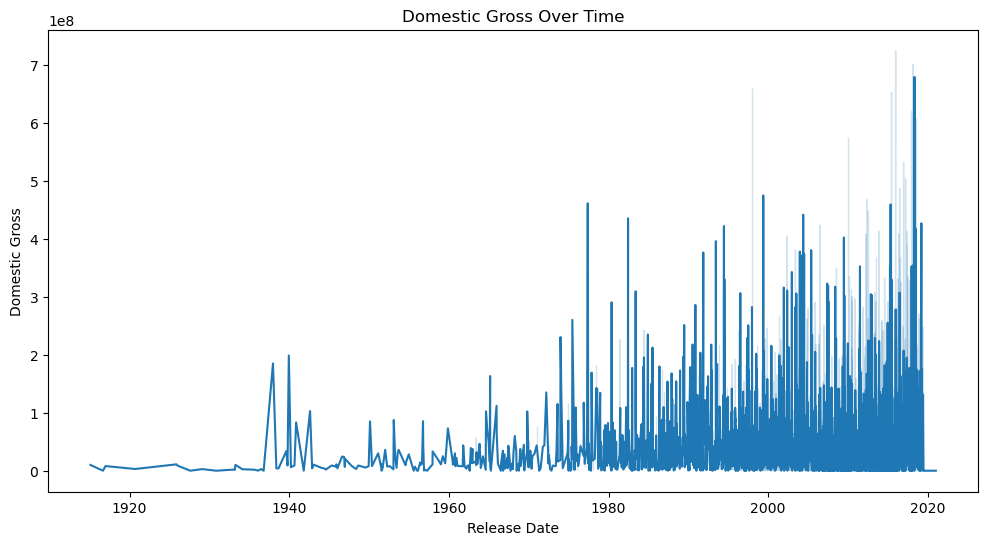

In [376]:
# Just getting a visual of domestic gross over the years

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_date', y='domestic_gross', data=tn_movie_budgets)
plt.title('Domestic Gross Over Time')
plt.xlabel('Release Date')
plt.ylabel('Domestic Gross')
plt.show()


## Filtering Data

In [16]:
# Cutting down the dates to the past 10 years to narrow the search for more relevant data

current_date = pd.to_datetime('today')
cutoff_date = current_date - pd.DateOffset(years=4)

recent_tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_date'] >= cutoff_date]

recent_tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,95,2020-12-31,Moonfall,150000000.0,0.0,0.0
1205,6,2020-12-31,Hannibal the Conqueror,50000000.0,0.0,0.0


In [15]:
# Subtracted the cost of production from the domestic gross to try to find profit

tn_movie_budgets['movie_profit'] = tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,335507625.0
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-169536125.0
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-307237650.0
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,128405868.0
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,303181382.0
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00,-7000.0
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05,42482.0
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,-3662.0
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00,-1400.0


# Close the im.db connection
It's always good practice to ensure you closed the connection

In [2]:

# Close the connection
conn.close()

NameError: name 'conn' is not defined